<a href="https://colab.research.google.com/github/Prajwalsrinvas/advent_of_haystack_2024/blob/main/Day_9_Haystack_MongoDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advent of Haystack: Day 9

In this challenge, you'll help Santa build a self-reflecting gift selection agent using Haystack and MongoDB Atlas! 🎅

The agent will help optimize gift selections based on children's wishlists and budget constraints, using MongoDB Atlas vector search for semantic matching and implementing self-reflection to ensure the best possible gift combinations.

**Components to use in this challenge:**
- [`OpenAITextEmbedder`](https://docs.haystack.deepset.ai/docs/openaitextembedder) for  query embedding
- [`MongoDBAtlasEmbeddingRetriever`](https://docs.haystack.deepset.ai/docs/) for finding relevant gifts
- [`PromptBuilder`](https://docs.haystack.deepset.ai/docs/promptbuilder) for creating the prompt
- [`OpenAIGenerator`](https://docs.haystack.deepset.ai/docs/openaigenerator) for  generating responses
- Custom `GiftChecker` component for self-reflection

## Setup

First, let's install the required packages:

In [1]:
!pip install haystack-ai mongodb-atlas-haystack tiktoken datasets colorama -q --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 391.4/391.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.3/454.3 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.8/109.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not c

## Configure Environment

- [OpenAI API Key](https://platform.openai.com/api-keys) if you'd like to use OpenAI embedding and text generation models
- [MongoDB Atlas project](https://www.mongodb.com/docs/atlas/getting-started/) with an Atlas cluster (free tier works). [Detailed Tutorial](https://www.mongodb.com/docs/guides/atlas/cluster/#create-a-cluster)
- Get your [connection string](https://www.mongodb.com/docs/atlas/tutorial/connect-to-your-cluster/#connect-to-your-atlas-cluster) and have `0.0.0.0/0` address in your network access list.
- Connection string looks like this `mongodb+srv://<db_username>:<db_password>@<clustername>.xxxxx.mongodb.net/?retryWrites=true...`

Set up your MongoDB Atlas and OpenAI credentials:

In [2]:
import os
import getpass
import re

conn_str = getpass.getpass("Enter your MongoDB connection string:")
conn_str = (re.sub(r'appName=[^\s]*', 'appName=devrel.ai.haystack_partner', conn_str)
            if 'appName=' in conn_str
            else conn_str + ('&' if '?' in conn_str else '?') + 'appName=devrel.ai.haystack_partner')
os.environ['MONGO_CONNECTION_STRING']=conn_str
os.environ['OPENAI_API_KEY'] = getpass.getpass("Enter your OpenAI API Key:")

Enter your MongoDB connection string:··········
Enter your OpenAI API Key:··········


## Sample Gift Dataset

Here's a starter dataset of gifts. Feel free to expand it with more options!

In [3]:
dataset = {
    "train": [
    {
        "title": "LEGO Star Wars Set",
        "price": "$49.99",
        "description": "Build your own galaxy with this exciting LEGO Star Wars set",
        "category": "Toys",
        "age_range": "7-12"
    },
    {
        "title": "Remote Control Car",
        "price": "$29.99",
        "description": "Fast and fun RC car with full directional control",
        "category": "Toys",
        "age_range": "6-10"
    },
    {
        "title": "Art Set",
        "price": "$24.99",
        "description": "Complete art set with paints, brushes, and canvas",
        "category": "Arts & Crafts",
        "age_range": "5-15"
    },
    {
        "title": "Science Kit",
        "price": "$34.99",
        "description": "Educational science experiments kit",
        "category": "Educational",
        "age_range": "8-14"
    },
    {
        "title": "Dollhouse",
        "price": "$89.99",
        "description": "Beautiful wooden dollhouse with furniture",
        "category": "Toys",
        "age_range": "4-10"
    },
    {
        "title": "Building Blocks Set",
        "price": "$39.99",
        "description": "Classic wooden building blocks in various shapes and colors",
        "category": "Educational",
        "age_range": "3-8"
    },
    {
        "title": "Board Game Collection",
        "price": "$44.99",
        "description": "Set of 5 classic family board games",
        "category": "Games",
        "age_range": "6-99"
    },
    {
        "title": "Puppet Theater",
        "price": "$59.99",
        "description": "Wooden puppet theater with 6 hand puppets",
        "category": "Creative Play",
        "age_range": "4-12"
    },
    {
        "title": "Robot Building Kit",
        "price": "$69.99",
        "description": "Build and program your own robot with this STEM kit",
        "category": "Educational",
        "age_range": "10-16"
    },
    {
        "title": "Play Kitchen",
        "price": "$79.99",
        "description": "Realistic play kitchen with sounds and accessories",
        "category": "Pretend Play",
        "age_range": "3-8"
    },
    {
        "title": "Musical Instrument Set",
        "price": "$45.99",
        "description": "Collection of kid-friendly musical instruments",
        "category": "Music",
        "age_range": "3-10"
    },
    {
        "title": "Sports Equipment Pack",
        "price": "$54.99",
        "description": "Complete set of kids' sports gear including ball, bat, and net",
        "category": "Sports",
        "age_range": "6-12"
    },
    {
        "title": "Magic Tricks Kit",
        "price": "$29.99",
        "description": "Professional magic set with instruction manual",
        "category": "Entertainment",
        "age_range": "8-15"
    },
    {
        "title": "Dinosaur Collection",
        "price": "$39.99",
        "description": "Set of 12 detailed dinosaur figures with fact cards",
        "category": "Educational",
        "age_range": "4-12"
    },
    {
        "title": "Craft Supply Bundle",
        "price": "$49.99",
        "description": "Comprehensive craft supplies including beads, yarn, and tools",
        "category": "Arts & Crafts",
        "age_range": "6-16"
    },
    {
        "title": "Coding for Kids Set",
        "price": "$64.99",
        "description": "Interactive coding kit with programmable robot and game cards",
        "category": "STEM",
        "age_range": "8-14"
    },
    {
        "title": "Dress Up Trunk",
        "price": "$49.99",
        "description": "Collection of costumes and accessories for imaginative play",
        "category": "Pretend Play",
        "age_range": "3-10"
    },
    {
        "title": "Microscope Kit",
        "price": "$59.99",
        "description": "Real working microscope with prepared slides and tools",
        "category": "Science",
        "age_range": "10-15"
    },
    {
        "title": "Outdoor Explorer Kit",
        "price": "$34.99",
        "description": "Nature exploration set with binoculars, compass, and field guide",
        "category": "Outdoor",
        "age_range": "7-12"
    },
    {
        "title": "Art Pottery Studio",
        "price": "$69.99",
        "description": "Complete pottery wheel set with clay and glazing materials",
        "category": "Arts & Crafts",
        "age_range": "8-16"
    }
]
}

## Initialize MongoDB Atlas

First, we need to set up our MongoDB Atlas collection and create a vector search index. This step is crucial for enabling semantic search capabilities:

In [5]:
 # Create collection gifts and add the vector index


from pymongo import MongoClient
from bson import json_util
from pymongo.operations import SearchIndexModel
import json
import time

client = MongoClient(os.environ['MONGO_CONNECTION_STRING'])
db = client['santa_workshop']
collection = db['gifts']

db.create_collection("gifts")


## create index
search_index_model = SearchIndexModel(
  definition={
    "fields": [
      {
        "type": "vector",
        "numDimensions": 1536,
        "path": "embedding",
        "similarity": "cosine"
      },
    ]
  },
  name="vector_index",
  type="vectorSearch",
)
result = collection.create_search_index(model=search_index_model)
print("New search index named " + result + " is building.")
# Wait for initial sync to complete
print("Polling to check if the index is ready. This may take up to a minute.")
predicate=None
if predicate is None:
  predicate = lambda index: index.get("queryable") is True
while True:
  indices = list(collection.list_search_indexes(result))
  if len(indices) and predicate(indices[0]):
    break
  time.sleep(5)
print(result + " is ready for querying.")
client.close()

New search index named vector_index is building.
Polling to check if the index is ready. This may take up to a minute.
vector_index is ready for querying.


## Initialize Document Store and Index Documents

Now let's set up the [MongoDBAtlasDocumentStore](https://docs.haystack.deepset.ai/docs/mongodbatlasdocumentstore) and index our gift data:

In [6]:
from haystack import Pipeline, Document
from haystack.document_stores.types import DuplicatePolicy
from haystack.components.writers import DocumentWriter
from haystack.components.embedders import OpenAIDocumentEmbedder
from haystack_integrations.document_stores.mongodb_atlas import MongoDBAtlasDocumentStore
from bson import json_util

# Initialize document store
document_store = MongoDBAtlasDocumentStore(
    database_name="santa_workshop",
    collection_name="gifts",
    vector_search_index="vector_index"
)

# Convert dataset to Haystack documents
insert_data = [
    Document(content=gift['title'], meta=json_util.loads(json_util.dumps(gift)))
    for gift in dataset['train']
]

# Create and run indexing pipeline
doc_writer = DocumentWriter(document_store=document_store, policy=DuplicatePolicy.SKIP)
doc_embedder = OpenAIDocumentEmbedder(
    model="text-embedding-3-small",
    meta_fields_to_embed=["description"]  # Include description in embeddings
)

indexing_pipe = Pipeline()
indexing_pipe.add_component(instance=doc_embedder, name="doc_embedder")
indexing_pipe.add_component(instance=doc_writer, name="doc_writer")
indexing_pipe.connect("doc_embedder.documents", "doc_writer.documents")

indexing_pipe.run({"doc_embedder": {"documents": insert_data}})

Calculating embeddings: 1it [00:01,  1.33s/it]


{'doc_embedder': {'meta': {'model': 'text-embedding-3-small',
   'usage': {'prompt_tokens': 241, 'total_tokens': 241}}},
 'doc_writer': {'documents_written': 20}}

## TODO: Create Gift Selection Pipeline

Now comes the fun part! Create a pipeline that can:
1. Take a gift request query
2. Find relevant gifts using vector search
3. Self-reflect on selections to optimize for budget and preferences

**HINT:** Learn how to write your component in [Docs: Creating Custom Components](https://docs.haystack.deepset.ai/docs/custom-components)

Here's the basic structure to get you started:

In [14]:
from haystack.components.generators import OpenAIGenerator
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack_integrations.components.retrievers.mongodb_atlas import MongoDBAtlasEmbeddingRetriever
from haystack.components.embedders import OpenAITextEmbedder
from colorama import Fore
from typing import List
from haystack import component
from IPython.display import display, Markdown

# Create a GiftChecker component for self-reflection
@component
class GiftChecker:
    @component.output_types(gifts_to_check=str, gifts=str)
    def run(self, replies: List[str]):
        # Hint: Check if the selection is optimal ('DONE') or needs improvement
        latest_message=replies[0]
        print(f'{latest_message=}')
        if 'DONE' in latest_message:
          display(Markdown('**OPTIMAL**'))
          return {'gifts':latest_message.replace('DONE','')}
        else:
          display(Markdown('**NEEDS IMPROVEMENT**'))
          return {'gifts_to_check':latest_message}

# Create your prompt template
prompt_template = """
    You are Santa's gift selection assistant. Below you have a list of available gifts with their prices.
    Based on the child's wishlist and budget, suggest appropriate gifts that maximize joy while staying within budget.

    Available Gifts:
    {% for doc in documents %}
        Gift: {{ doc.content }}
        Price: {{ doc.meta['price']}}
        Age Range: {{ doc.meta['age_range']}}
    {% endfor %}

    Query: {{query}}
    {% if gifts_to_check %}
        Previous gift selection: {{gifts_to_check[0]}}
        Can we optimize this selection for better value within budget?
        If optimal, say 'DONE' and return the selection
        If not, suggest a better combination
    {% endif %}

    Gift Selection:
"""

# Create and connect your pipeline components
gift_pipeline = Pipeline(max_runs_per_component=5)

# Add your components here!
# Hint: You'll need:
# - OpenAITextEmbedder for query embedding
# - MongoDBAtlasEmbeddingRetriever for finding relevant gifts
# - PromptBuilder for creating the prompt
# - GiftChecker for self-reflection
# - OpenAIGenerator for generating responses

text_embedder = OpenAITextEmbedder(model='text-embedding-3-small')
retriever = MongoDBAtlasEmbeddingRetriever(document_store=document_store)
prompt_builder=PromptBuilder(template=prompt_template)
gift_checker = GiftChecker()
llm = OpenAIGenerator(model='gpt-4o')

# Connect your components here!
# Hint: Think about the flow of data between components

gift_pipeline.add_component(name='text_embedder',instance=text_embedder)
gift_pipeline.add_component(name='retriever',instance=retriever)
gift_pipeline.add_component(name='prompt_builder',instance=prompt_builder)
gift_pipeline.add_component(name='gift_checker',instance=gift_checker)
gift_pipeline.add_component(name='llm',instance=llm)

gift_pipeline.connect('text_embedder.embedding','retriever.query_embedding')
gift_pipeline.connect('retriever','prompt_builder')
gift_pipeline.connect('prompt_builder','llm')
gift_pipeline.connect('llm','gift_checker')
gift_pipeline.connect('gift_checker','prompt_builder')


🚅 Components
  - text_embedder: OpenAITextEmbedder
  - retriever: MongoDBAtlasEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - gift_checker: GiftChecker
  - llm: OpenAIGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)
  - gift_checker.gifts_to_check -> prompt_builder.gifts_to_check (str)
  - llm.replies -> gift_checker.replies (List[str])

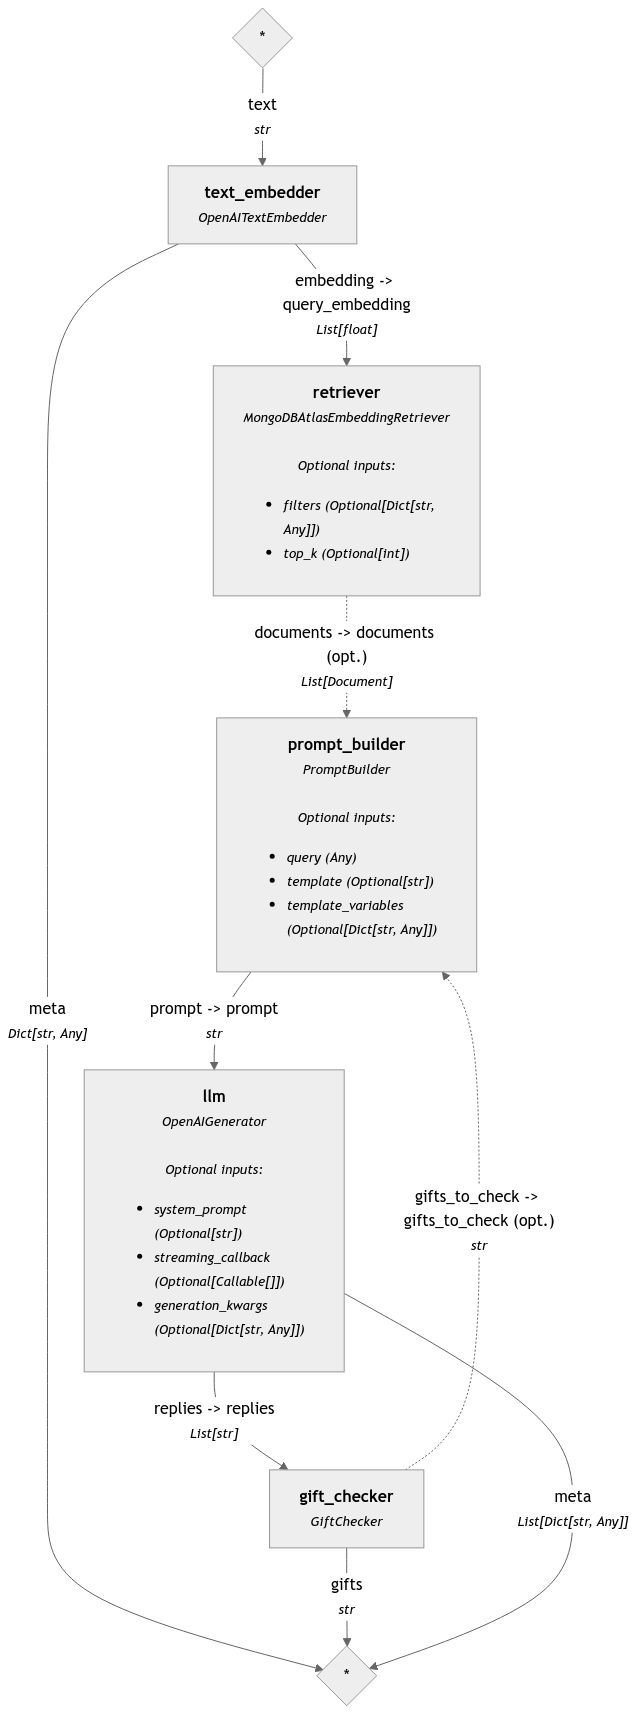

In [15]:
gift_pipeline.show()

## Test Your Agent

Once you've built your pipeline, test it with different scenarios:

In [16]:
# Test queries to try:
queries = [
    "Find gifts for a 9-year-old who loves science and building things. Budget: $100",
    "Need gifts for a creative 6-year-old interested in art. Budget: $50",
    "Looking for educational toys for a 12-year-old. Budget: $75"
]

for query in queries:
  # Run the pipeline and print the results
  output=gift_pipeline.run({'text_embedder':{'text':query},'prompt_builder':{'query':query}})
  display(Markdown(output['gift_checker']['gifts']))
  print('-'*100)

latest_message="For a 9-year-old who loves science and building things, and with a budget of $100, we want to select gifts that will maximize joy and stay within the budget. Here's a suggested selection:\n\n1. **Science Kit**\n   - Price: $34.99\n   - This aligns well with the child's interest in science.\n\n2. **LEGO Star Wars Set**\n   - Price: $49.99\n   - This is perfect for a child interested in building things and fits within the age range.\n\nAdding these together, the total comes to $84.98, which stays within the $100 budget and maximizes the child's interests in science and building activities."


**NEEDS IMPROVEMENT**

latest_message="To find the optimal gift selection for a 9-year-old who loves science and building things, we need to choose gifts that maximize joy while staying within the $100 budget. Let's evaluate the gifts that match the interests and age range:\n\n1. **Science Kit**\n   - Price: $34.99\n   - Age Range: 8-14\n\n2. **LEGO Star Wars Set**\n   - Price: $49.99\n   - Age Range: 7-12\n\n3. **Building Blocks Set**\n   - Price: $39.99\n   - Age Range: 3-8\n\n4. **Robot Building Kit**\n   - Price: $69.99\n   - Age Range: 10-16 (but close enough, as the child loves building)\n\nLet's consider combinations:\n\n### Initial Selection:\n- **Science Kit** ($34.99) + **LEGO Star Wars Set** ($49.99) = $84.98\n\nThis selection leaves $15.02, which is insufficient for any additional gift from the list.\n\n### Alternate Selections:\n1. **Science Kit** ($34.99) + **Building Blocks Set** ($39.99) = $74.98\n   - Leaves a budget of $25.02, which is not enough for an additional gift.\n\n2. **Science Kit*

**OPTIMAL**

/usr/local/lib/python3.10/dist-packages/haystack/core/pipeline/pipeline.py:523: RuntimeWarning: Pipeline is stuck running in a loop. Partial outputs will be returned. Check the Pipeline graph for possible issues.
  warn(RuntimeWarning(msg))


To find the optimal gift selection for a 9-year-old who loves science and building things, we need to choose gifts that maximize joy while staying within the $100 budget. Let's evaluate the gifts that match the interests and age range:

1. **Science Kit**
   - Price: $34.99
   - Age Range: 8-14

2. **LEGO Star Wars Set**
   - Price: $49.99
   - Age Range: 7-12

3. **Building Blocks Set**
   - Price: $39.99
   - Age Range: 3-8

4. **Robot Building Kit**
   - Price: $69.99
   - Age Range: 10-16 (but close enough, as the child loves building)

Let's consider combinations:

### Initial Selection:
- **Science Kit** ($34.99) + **LEGO Star Wars Set** ($49.99) = $84.98

This selection leaves $15.02, which is insufficient for any additional gift from the list.

### Alternate Selections:
1. **Science Kit** ($34.99) + **Building Blocks Set** ($39.99) = $74.98
   - Leaves a budget of $25.02, which is not enough for an additional gift.

2. **Science Kit** ($34.99) + **Robot Building Kit** ($69.99) = $104.98
   - Exceeds budget.

3. **LEGO Star Wars Set** ($49.99) + **Building Blocks Set** ($39.99) = $89.98
   - Leaves a budget of $10.02, which is not enough for an additional gift.

Therefore, the initial selection of the **Science Kit** and **LEGO Star Wars Set** maximizes the child's interests and uses $84.98 of the $100 budget efficiently. There is no better combination within this list to increase value without exceeding the budget.

**Response**:  with the current selection.

----------------------------------------------------------------------------------------------------
latest_message="Given the budget of $50 and the interest in art for a creative 6-year-old, let's prioritize gifts that match the child's interests and stay within budget.\n\n1. **Art Set** \n   - Price: $24.99\n   - This gift is perfect for encouraging creativity in art and falls within your budget. It also leaves room for potentially adding another small gift.\n\n2. **Craft Supply Bundle**\n   - Price: $49.99\n   - Although it just fits within the budget, it offers a wide range of creative materials that align well with the child's interests in art.\n\nThese gifts fit the child's interest in art and stay within the budget. If the intent is to maximize the child's joy while considering the available funds, the combination of the Art Set allows for a diverse creative experience and budget flexibility."


**NEEDS IMPROVEMENT**

latest_message='Considering the wishlist and budget, and focusing on gifts that are age-appropriate and art-related for a creative 6-year-old:\n\n1. **Art Set** - $24.99\n   - An excellent option as it is specifically art-related and well within the budget.\n\nThe current selection only included one gift, labeled as "G", without specification. To optimize for better value within a $50 budget:\n\n**Optimal Gift Selection:**\n- **Art Set** for $24.99\n- **Craft Supply Bundle** for $49.99 (This is the previous gift, but evaluating both options would only allow for the Art Set given the budget constraint, as Craft Supply exceeds $50 alone)\n\nSince we want to stick to budget and the Art Set fits within both the budget and the age range while aligning with the art interest, the best possible selection for maximizing joy within the $50 constraint would be:\n\n- **Art Set** - $24.99\n\nWith the remaining budget, unfortunately, no other individual art-related item fits under the remaining amou

**OPTIMAL**

Considering the wishlist and budget, and focusing on gifts that are age-appropriate and art-related for a creative 6-year-old:

1. **Art Set** - $24.99
   - An excellent option as it is specifically art-related and well within the budget.

The current selection only included one gift, labeled as "G", without specification. To optimize for better value within a $50 budget:

**Optimal Gift Selection:**
- **Art Set** for $24.99
- **Craft Supply Bundle** for $49.99 (This is the previous gift, but evaluating both options would only allow for the Art Set given the budget constraint, as Craft Supply exceeds $50 alone)

Since we want to stick to budget and the Art Set fits within both the budget and the age range while aligning with the art interest, the best possible selection for maximizing joy within the $50 constraint would be:

- **Art Set** - $24.99

With the remaining budget, unfortunately, no other individual art-related item fits under the remaining amount of $25.01. Thus:

**** - The optimal and joyful selection within the provided budget for a creative 6-year-old interested in art is the "Art Set" for $24.99.

----------------------------------------------------------------------------------------------------
latest_message="Based on the wish for educational toys for a 12-year-old with a budget of $75, we should focus on gifts that are both within the budget and suitable for their age range. Here's a suggested list:\n\n1. **Science Kit**: \n   - Price: $34.99 \n   - Age Range: 8-14 \n   - This is a great educational gift that will inspire curiosity about science.\n\n2. **Coding for Kids Set**:\n   - Price: $64.99 \n   - Age Range: 8-14\n   - While this would individually exceed half of the budget, it's an excellent choice to dive into coding and technology.\n\nAlternatively, you can combine the Science Kit and the Magic Tricks Kit:\n\n1. **Science Kit**: \n   - Price: $34.99 \n   - Age Range: 8-14\n\n2. **Magic Tricks Kit**:\n   - Price: $29.99 \n   - Age Range: 8-15\n\nCombined Cost: $34.99 + $29.99 = $64.98\n\nThis combination stays within the $75 budget and provides both variety and a wid

**NEEDS IMPROVEMENT**

latest_message="For a 12-year-old interested in educational toys and with a budget of $75, let's review the available gifts and see if we can offer a selection that maximizes joy and aligns with your criteria. The previous selection was Gift B, which is the Musical Instrument Set priced at $45.99. \n\nLet's explore other possible combinations:\n\n1. **Science Kit** ($34.99) and **Magic Tricks Kit** ($29.99)\n   - Total: $64.98\n   - Offers two educational activities\n   - Within budget\n\n2. **Board Game Collection** ($44.99)\n   - Total: $44.99\n   - Educational and fun for a wide age range\n   - Leaves room in budget for additional small gifts or future savings\n\n3. **Dinosaur Collection** ($39.99) and **Magic Tricks Kit** ($29.99)\n   - Total: $69.98\n   - Combines education and entertainment\n   - Within budget\n\n4. **Sports Equipment Pack** ($54.99) \n   - Total: $54.99\n   - Encourages physical activity and skills development\n   - Leaves room in budget for additional small gif

**OPTIMAL**

For a 12-year-old interested in educational toys and with a budget of $75, let's review the available gifts and see if we can offer a selection that maximizes joy and aligns with your criteria. The previous selection was Gift B, which is the Musical Instrument Set priced at $45.99. 

Let's explore other possible combinations:

1. **Science Kit** ($34.99) and **Magic Tricks Kit** ($29.99)
   - Total: $64.98
   - Offers two educational activities
   - Within budget

2. **Board Game Collection** ($44.99)
   - Total: $44.99
   - Educational and fun for a wide age range
   - Leaves room in budget for additional small gifts or future savings

3. **Dinosaur Collection** ($39.99) and **Magic Tricks Kit** ($29.99)
   - Total: $69.98
   - Combines education and entertainment
   - Within budget

4. **Sports Equipment Pack** ($54.99) 
   - Total: $54.99
   - Encourages physical activity and skills development
   - Leaves room in budget for additional small gifts or future savings

Since the question specifically asks for educational toys, I recommend selection 1, which includes the Science Kit and Magic Tricks Kit. This combination maximizes educational value while staying within the budget.

Selection: **Science Kit** and **Magic Tricks Kit**

If this selection aligns with the desired criteria, please confirm by saying ''.

----------------------------------------------------------------------------------------------------


## Next Steps (Bonus)

Once you have the basic pipeline working, try these extensions:
1. Add sentiment analysis to evaluate gift joy potential
2. Implement gift bundle optimization
3. Add previous gift tracking to ensure variety
4. Enhance the prompt to consider seasonal availability
5. Add gift wrapping suggestions based on the selected gifts

Good luck! 🎄✨